## **Train of thought🚄**

As the data set is not built in we used a custom class to load the images by taking the img name and directory and represent it with the label then the dataloader will transform it to tensor which we can pass to the model for training 

By analyzing the data we found the 1 label appering approximately 3 times more than the zero label 
so we decided to downsample the 1 label by removing about half the data with 1 label 

By trying diffrent models the best model that worked for us was Densnet121



# **Libraries Used**

In [1]:
from __future__ import print_function 
from __future__ import division
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import copy
from tqdm import tqdm
from torchvision.transforms import InterpolationMode

# **Checking GPU**

In [2]:
# Check for the presence of a GPU
print("GPU is available: ", torch.cuda.is_available())

# Get information about the available GPUs
print(torch.cuda.device_count(), "GPU(s) available:")
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GPU is available:  True
1 GPU(s) available:
Tesla P100-PCIE-16GB


# **Image Details**

In [3]:
image = Image.open('/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/train/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')
 
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

JPEG
(256, 256)
RGB


In [4]:
train_path = '/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/train'
test_path = '/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/test'

# **Creating a Custom Class to load Data🤓**

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None,transform1=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.transform1 = transform1
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform and label == 0:
            image = self.transform(image)
        if self.transform1 and label == 1 :
            image = self.transform1(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# **Removing the half the 1 labeled data**

In [6]:
df = pd.read_csv('/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/train.csv')

In [7]:
for i in range(len(df)):
    if df.loc[i,'Label'] == 1:
        if i%2 != 0:
            #print(df.loc[i,'Label'])
            df = df.drop(i)

In [8]:
len(df)

#df.head(1000)
df.to_csv('df.csv',index=False)

In [9]:
count=0
for index, row in df.iterrows():
    if row["Label"] == 1:
        count+=1
print(count)
count = 0
for index, row in df.iterrows():
    if row["Label"] == 0:
        count+=1

count

3555


2557

# **Loading the data**

In [10]:
# Batch size for training (change depending on how much memory you have)
batch_size = 64
test_batch = 128


train_dataset = CustomImageDataset('/kaggle/working/df.csv',train_path)
testset = CustomImageDataset('/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/test.csv',test_path)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
trainset, valset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=test_batch,
                                         shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch,
                                         shuffle=False, num_workers=2)

image_datasets = {'train':trainset,'val':valset}

dataloaders_dict = {'train':trainloader,'val':valloader}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Visualizing the data🧐**

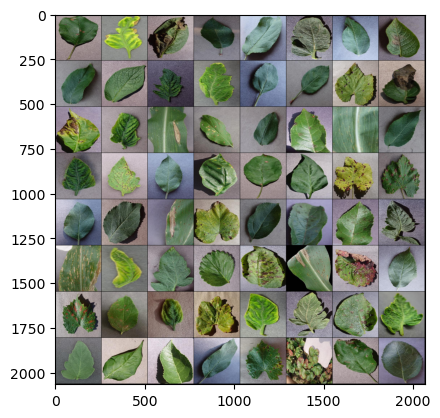

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))


In [12]:
def plot(train_acc,test_acc): # plotting the line 1 points
    plt.plot([i+1 for i in range(len(train_acc))], train_acc, label = "Train")
    # plotting the line 2 points
    plt.plot([i+1 for i in range(len(test_acc))], test_acc, label = "Val")

    # naming the x axis
    plt.xlabel('epoch')
    # naming the y axis
    plt.ylabel('Accuracy')
    # giving a title to my graph
    plt.title('Train Val acc')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

# **Function for Training the model🦾🦾**


In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_history = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 labels= labels.sub(labels,1)
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(float(epoch_acc))
            else:
                train_acc_history.append(float(epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history

In [14]:
# A function to freeze all layers of the model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# **Function to initialize model model⚙⚙**

In [15]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size



# **Initializing the model and used parameters**

In [16]:

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

# Number of classes in the dataset
num_classes = 2
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract)

# Print the model we just instantiated
print(model_ft)

# Number of epochs to train for 
num_epochs = 4



/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# **Choosing optmizer SGD and Crossentropy loss**

In [17]:

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# **Training the model🥊**

In [18]:
# Train and evaluate
model_ft, val_hist,train_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0/3
----------
train Loss: 0.2404 Acc: 0.8981


 25%|██▌       | 1/4 [00:50<02:30, 50.14s/it]

val Loss: 0.0707 Acc: 0.9820

Epoch 1/3
----------
train Loss: 0.0433 Acc: 0.9896


 50%|█████     | 2/4 [01:35<01:34, 47.45s/it]

val Loss: 0.0395 Acc: 0.9877

Epoch 2/3
----------
train Loss: 0.0229 Acc: 0.9947


 75%|███████▌  | 3/4 [02:21<00:46, 46.63s/it]

val Loss: 0.0275 Acc: 0.9918

Epoch 3/3
----------
train Loss: 0.0119 Acc: 0.9975


100%|██████████| 4/4 [03:07<00:00, 46.78s/it]

val Loss: 0.0228 Acc: 0.9935

Training complete in 3m 7s
Best val Acc: 0.993459


# **Ploting The Train and validation accuracies📈**

In [19]:
train = []
val  = []
for i in train_hist:
    train.append(float(i))
for i in val_hist:
    val.append(float(i))

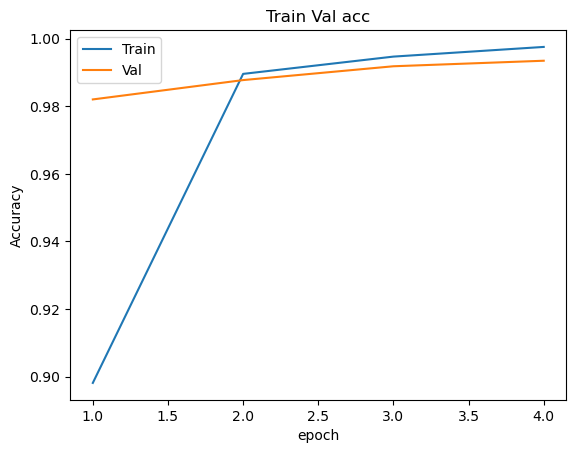

In [20]:
plot(train,val)

# **Testing the model on test data😎**

In [21]:
preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.float()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)

# **Calculating the inference time⏲**

In [22]:
infloader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=False,num_workers = 2)
image,label = next(iter(infloader))
start = time.time()
outputs = model_ft(image.float().to(device))
end = time.time()
inf_time = end-start
print("inf time = ",inf_time)

inf time =  0.05570387840270996


# **Loading the model outputs to the submission file🔋**

In [23]:
preds_transformed = [x.item() for x in torch.cat(preds)]
preds_transformed[:5]


[0, 0, 0, 0, 0]

In [24]:
test = pd.read_csv("/kaggle/input/ieeenu-cis-plant-binary-classifi-nuaih-entry/PlantFinal Files-20230213T190104Z-001/Final Files/test.csv")
test['Label']=preds_transformed
test.to_csv("sol.csv",index=False)

# **Counting the predicted label**

In [25]:
count=0
for index, row in test.iterrows():
    if row["Label"] == 1:
        count+=1
print(count)
count = 0
for index, row in test.iterrows():
    if row["Label"] == 0:
        count+=1
count

350


1050